In [1]:
import mle as mle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta, datetime
import backtesting as bt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from copy import copy

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

### Create data for analysis

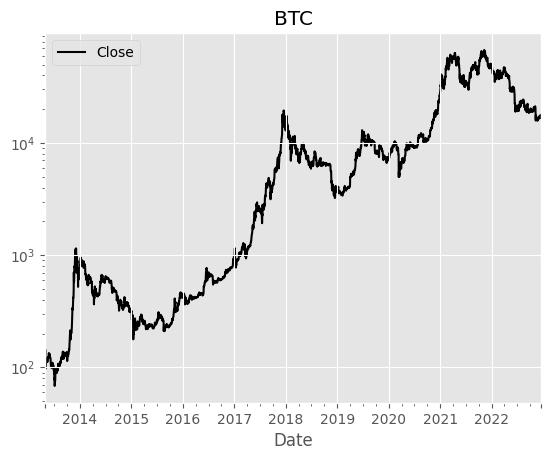

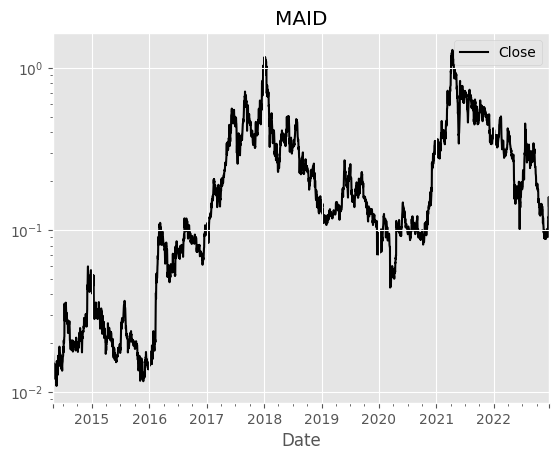

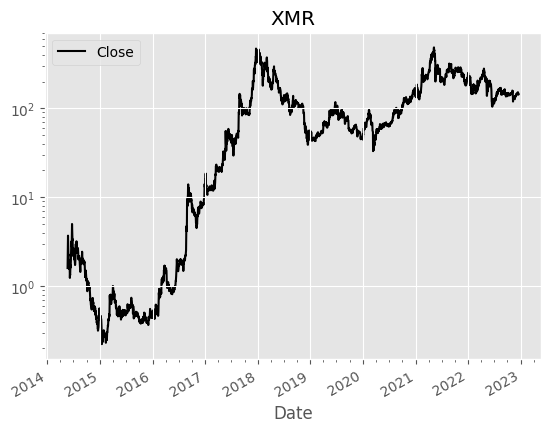

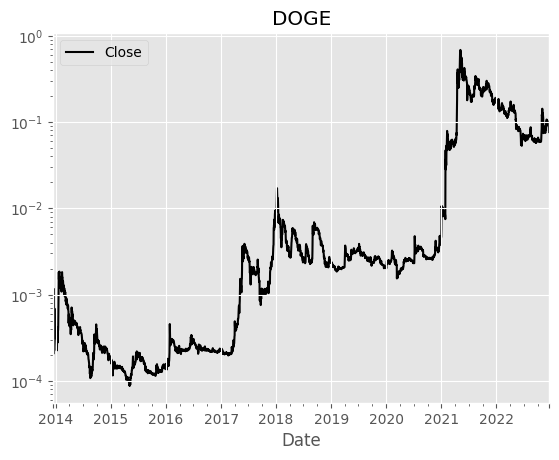

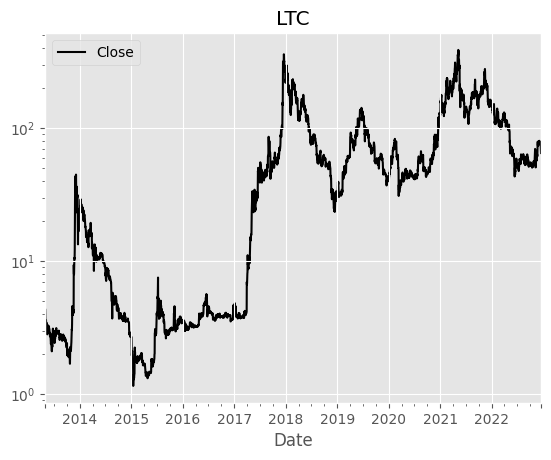

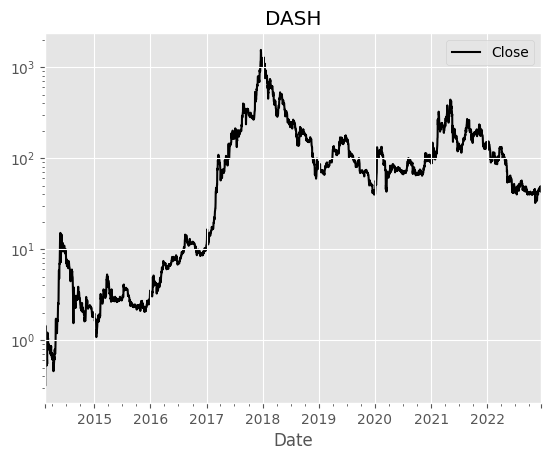

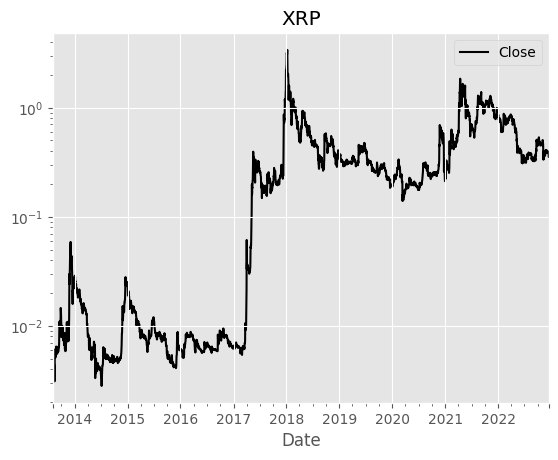

In [2]:
coins = ['BTC', 'MAID', 'XMR', 'DOGE', 'LTC', 'DASH', 'XRP']
dfs = dict()
for coin in coins:
    df = pd.read_csv(
        f'https://raw.githubusercontent.com/georgec123/sa_cw/main/data/prices/{coin}.csv').set_index('Date').sort_index()
    df.index = pd.to_datetime(df.index)
    df['log_return'] = -np.log(1 + df['Close'].pct_change())
    dfs[coin.lower()] = df.dropna()
    months = mdates.MonthLocator((1, 4, 7, 10))
    
    ax = plt.subplot()
    ax = df[['Close']].plot(ax=ax,logy=True, color='k', zorder=-10)
    
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.tick_bottom()
    
    plt.title(coin)
    plt.show()


best_dists = {
    'MAID': 'Laplace',
    'BTC': 'Generalized Hyperbolic',
    'DASH': 'Normalized Inverse Gaussian',
    'XRP': 'Normalized Inverse Gaussian',
    'XMR': 'Normalized Inverse Gaussian',
    'LTC': 'Generalized Hyperbolic',
    'DOGE': 'Generalized T'
}


### Fit models to all data

In [3]:
dists = [mle.Laplace, mle.SkewT, mle.SkewedStudent, mle.GeneralizedT,
         mle.NormalizedInverseGaussian, mle.GeneralizedHyperbolic, mle.StudentT,
         mle.AsymmetricStudentT]

end_date = pd.to_datetime('28-02-2017', format='%d-%m-%Y')
start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')

info_list = []

for coin in coins:
    coin_df = dfs[coin.lower()]
    df = coin_df[(coin_df.index >= start_date) & (coin_df.index <= end_date)]
    for dist in dists:

        fitted_dist = dist()
        fitted_dist.mle(df['log_return'])
        info_dict = fitted_dist.info_dict()
        info_dict['coin'] = coin

        info_list.append(info_dict)
info_df = pd.DataFrame(info_list)


### ACF plots show no serial correlation

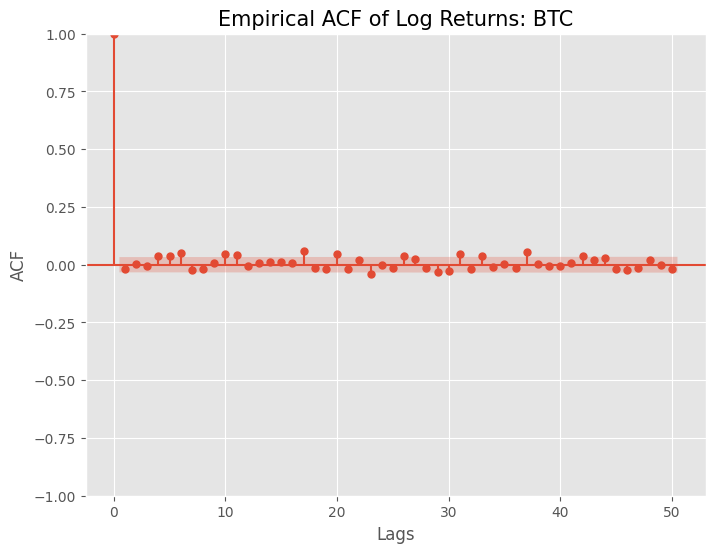

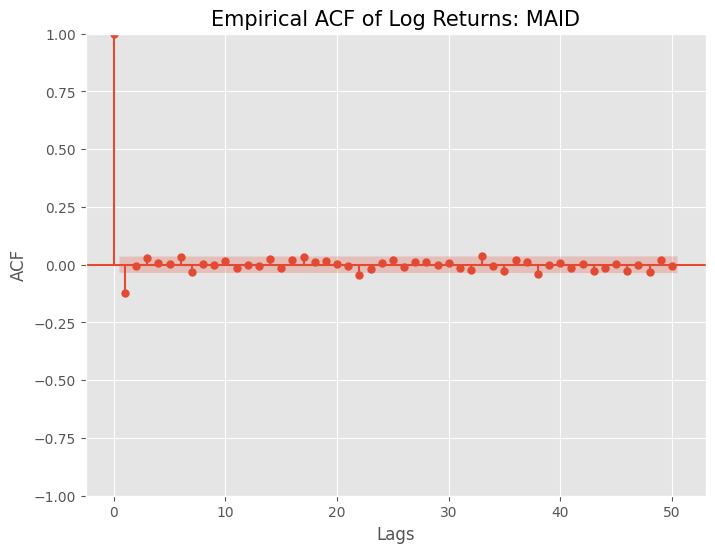

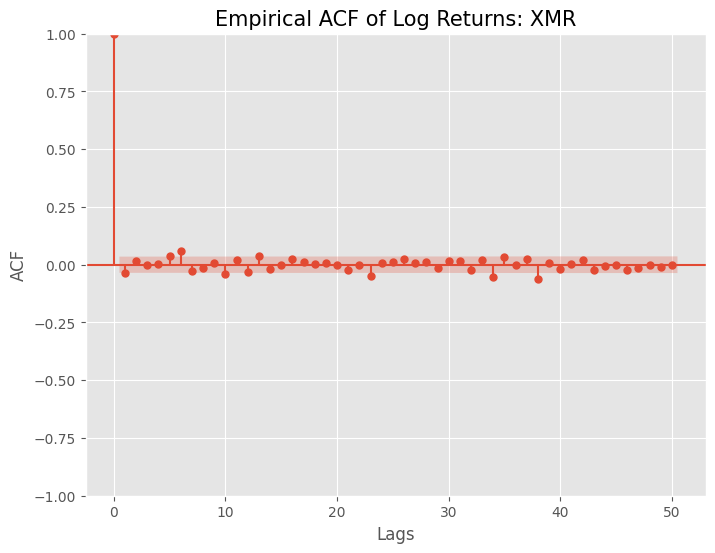

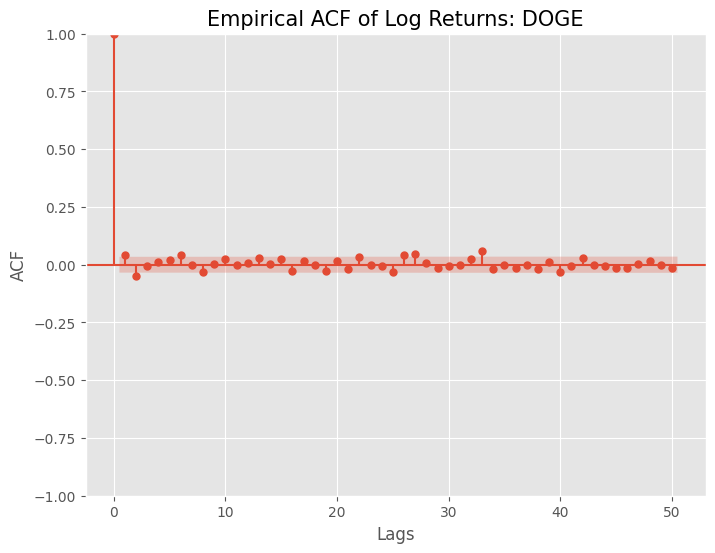

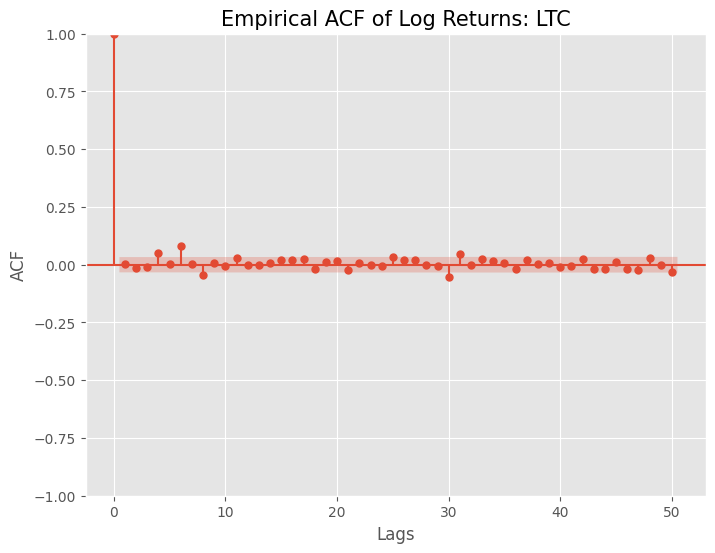

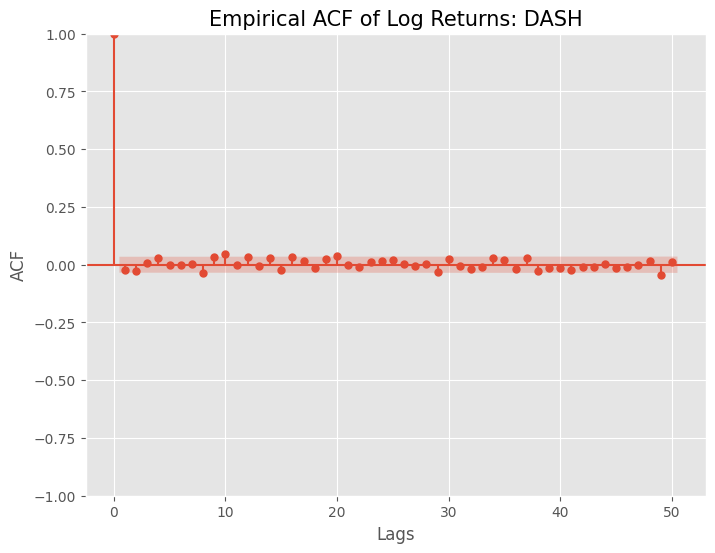

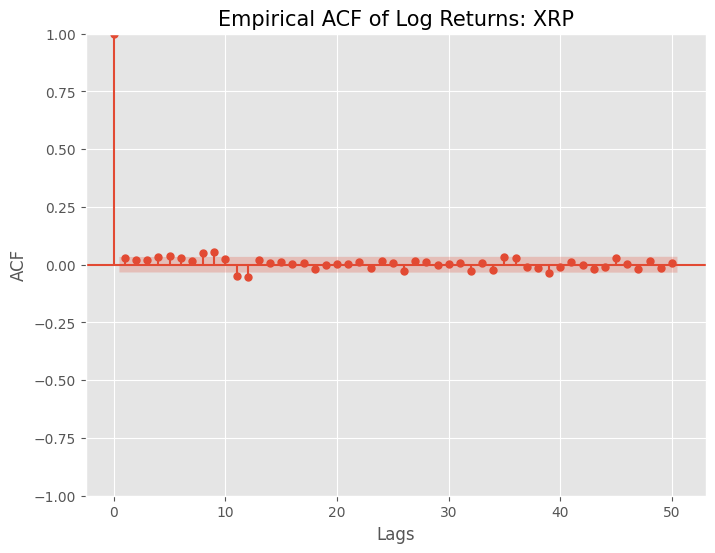

In [5]:
for coin in coins:
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.graphics.tsa.plot_acf(dfs[coin.lower()]['log_return'].dropna(
    ), lags=50, title="Empricial ACF of log returns", ax=ax)
    plt.title(f'Empirical ACF of Log Returns: {coin}', size=15)
    plt.xlabel("Lags", size=12)
    plt.ylabel("ACF", size=12)
    plt.savefig(f'../plots/acf/{coin}_acf.png')
    plt.show()


### Breusch-Pegan Test to show no evidence of Heteroskedasticity

In [20]:
f = 'log_return ~ Date'
end_date = pd.to_datetime('28-02-2020', format='%d-%m-%Y')
start_date = pd.to_datetime('28-02-2014', format='%d-%m-%Y')

for coin in coins:
    df_coin = dfs[coin.lower()]
    df_to_fit = df_coin[(df_coin.index >= start_date)
                        & (df_coin.index <= end_date)]
    f_model = ols(formula=f, data=df_to_fit.reset_index()).fit()
    test_result = sms.het_breuschpagan(f_model.resid, f_model.model.exog)

    lms, p_val, _, _ = test_result
    names = ['Lagrange multiplier statistic', 'p-value']
    print(f"{coin}: Lagrange multiplier statistic - {lms}. P-value {p_val:.4f}")


BTC: Lagrange multiplier statistic - 2192.0. P-value 0.4900
MAID: Lagrange multiplier statistic - 2132.0. P-value 0.4898
XMR: Lagrange multiplier statistic - 2108.0. P-value 0.4898
DOGE: Lagrange multiplier statistic - 2192.0. P-value 0.4900
LTC: Lagrange multiplier statistic - 2192.0. P-value 0.4900
DASH: Lagrange multiplier statistic - 2192.0. P-value 0.4900
XRP: Lagrange multiplier statistic - 2192.0. P-value 0.4900


### Add qq plots


In [24]:
def qqplot(pydist):
    qs = list(np.linspace(0.01, 0.25, 12)) + \
        list(np.linspace(0.26, 0.75, 10))+list(np.linspace(0.76, 0.99, 12))

    quantiles = []
    for i in qs:
        q = pydist.quantile(i)
        quantiles.append(q)

    observed_quantiles = np.quantile(pydist.data.dropna().values, qs)
    _min = min(min(observed_quantiles), min(quantiles))
    _max = max(max(observed_quantiles), max(quantiles))
    fig, ax = plt.subplots()
    ax.scatter(quantiles, observed_quantiles)
    ax.set_aspect('equal', adjustable='box')

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.set_ylabel('Obseved quantiles')
    ax.set_xlabel('Theoretical quantiles')

    return fig, ax



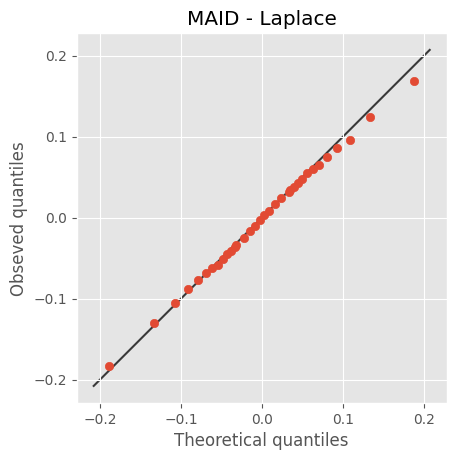

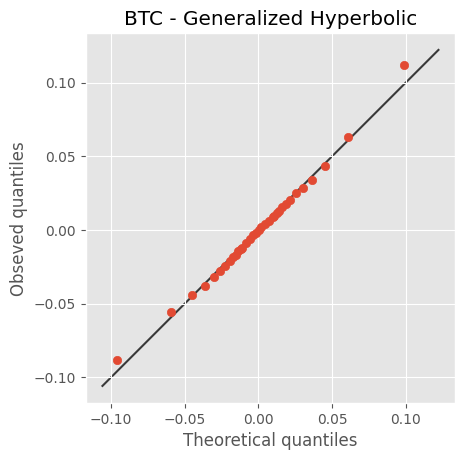

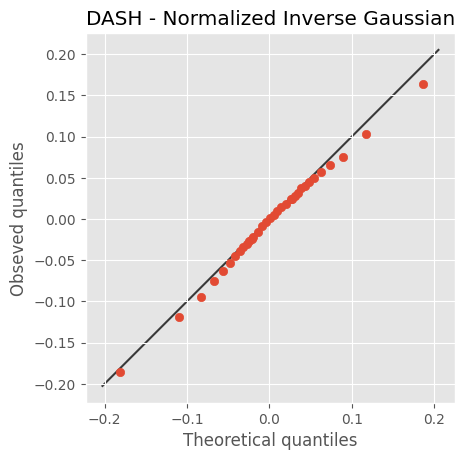

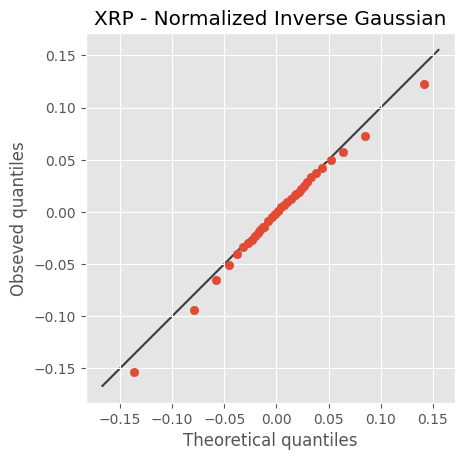

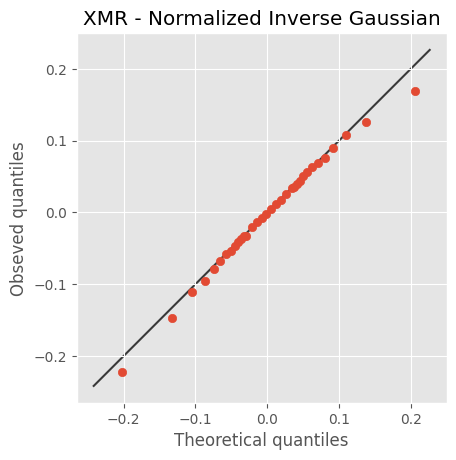

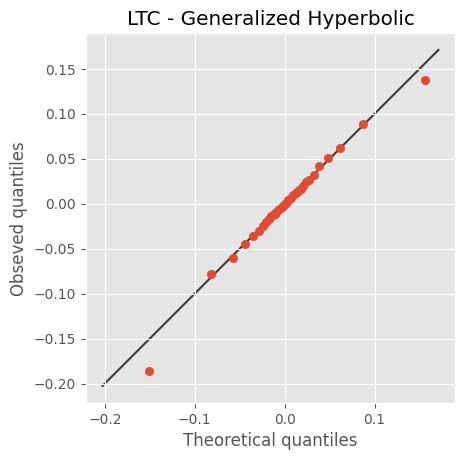

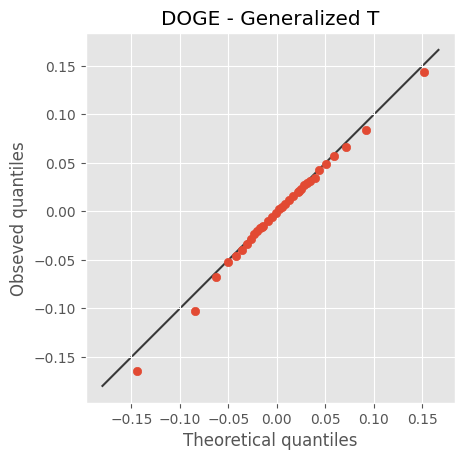

In [25]:

for coin, dist in best_dists.items():

    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    fig, ax = qqplot(pydist)
    ax.set_title(f"{coin} - {pydist.name}")
    plt.savefig(f'../plots/qq/{coin}_qq.png')
    plt.show()


### Analyse fit stability over time 

- Calculate fit parameters over a rolling window
- Plot data and save to file

In [26]:
# ~ 9m runtime

info_list = []
jump = 90
start_to_end_days = 981

start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')
end_date = start_date + timedelta(days=start_to_end_days)


while end_date <= datetime.now():

    for coin in coins:
        coin_df = dfs[coin.lower()]
        df = coin_df[(coin_df.index >= start_date)
                     & (coin_df.index <= end_date)]
        # df = coin_df
        for dist in dists:

            fitted_dist = dist()
            fitted_dist.mle(df['log_return'])
            info_dict = fitted_dist.info_dict()
            info_dict['coin'] = coin
            info_dict['start_date'] = start_date
            info_dict['end_date'] = end_date

            info_list.append(info_dict)

    start_date = start_date + timedelta(days=jump)
    end_date = start_date + timedelta(days=start_to_end_days)
params_over_time = pd.DataFrame(info_list)


for coin in coins:

    tmp = params_over_time[params_over_time['coin'] == coin]
    tmp = tmp[['end_date', 'dist', 'AIC']].set_index('end_date')
    tmp = tmp.pivot(columns='dist')

    tmp.columns = [col[1] for col in tmp.columns]

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    ax1 = tmp.plot(ax=ax1)
    ax1.set_title(f"{coin.upper()}")
    ax1.set_ylabel('AIC')
    ax2.set_xlabel('')

    ax1.legend(loc=2, fontsize=8)

    ax2 = tmp.rank(axis=1).plot(ax=ax2)
    ax2.set_ylabel('Ranking')
    ax2.set_xlabel('End Date')
    ax2.get_legend().remove()

    plt.savefig(f'../plots/fit_over_time/{coin}.png')
    plt.clf()


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

### Kupiec’s plots

In [ ]:
quantiles = np.linspace(0.9, 0.999, 51)

for coin, dist in best_dists.items():
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]
    
    fig, axs = plt.subplots(2,2, sharey='row', sharex='row', figsize=(8,8))
    
    axs[0][0] = pydist.kupic_plot(quantiles=quantiles, ax=axs[0][0])
    
    fig.suptitle(f"{coin} - {dist}")
    
    dist_copy = copy(pydist)

    df = dfs[coin.lower()]
    df = df[df.index>=start_date]
    
    dist_copy.data = df['log_return']

    axs[0][1] = dist_copy.kupic_plot(quantiles=quantiles, ax=axs[0][1])
    
    axs[0][0].set_ylabel("p-value")
    axs[1][0].set_ylabel("Density")

    axs[0][1].set_xlabel("q")
    axs[0][0].set_xlabel("q")

    axs[1][1].set_xlabel("log_return")
    axs[1][0].set_xlabel("log_return")

    pydist.plot_dist(ax=axs[1][0])
    dist_copy.plot_dist(ax=axs[1][1])

    axs[1][0].set_title('')
    axs[1][1].set_title('')

    axs[0][0].set_title('Training Data')
    axs[0][1].set_title('All Data')

    plt.savefig(f"../plots/kupiec/{coin}_alldata.png")
    
    plt.show()
    
    


## K-S Test

In [41]:

for coin, dist in best_dists.items():

    # get pydist
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    df = dfs[coin.lower()]
    df = df[df.index >= start_date]
    df['log_return']

    # vectorise cdf so it works with scipy ks
    def cdf(x): return np.vectorize(pydist.cdf)(x)

    ks_insample = stats.kstest(pydist.data.values, cdf,)
    ks_outsample = stats.kstest(
        df['log_return'].values, cdf,alternative='greater')

    print(f"{coin} - pval (insample): {ks_insample[1]:.5f}. "
          f"pval (out of sample): {ks_outsample[0]:.5f}")


MAID - pval (insample): 0.65692. pval (out of sample): 0.03044
BTC - pval (insample): 0.62984. pval (out of sample): 0.08338
DASH - pval (insample): 0.46665. pval (out of sample): 0.06124
XRP - pval (insample): 0.42997. pval (out of sample): 0.10012
XMR - pval (insample): 0.96327. pval (out of sample): 0.09011
LTC - pval (insample): 0.98534. pval (out of sample): 0.15185
DOGE - pval (insample): 0.71563. pval (out of sample): 0.06209


## VaR plots

In [28]:
q = np.linspace(0.01, 0.99, 101)

euro = pd.read_csv('../data/USD_EUR Historical Data.csv')
euro['log_return'] = -np.log(1 + euro['Price'].pct_change())
euro_quantile = np.quantile(euro['log_return'].dropna(), q)


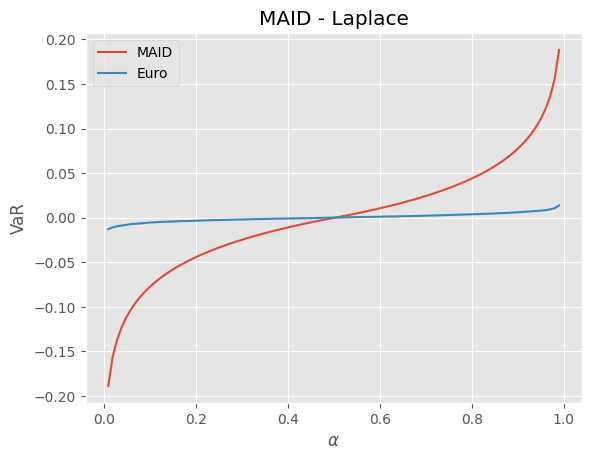

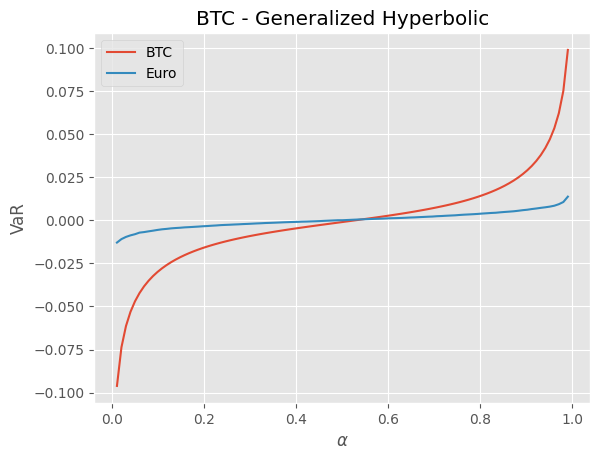

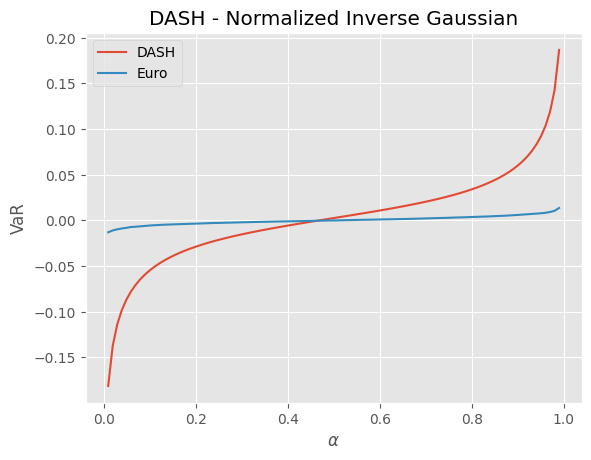

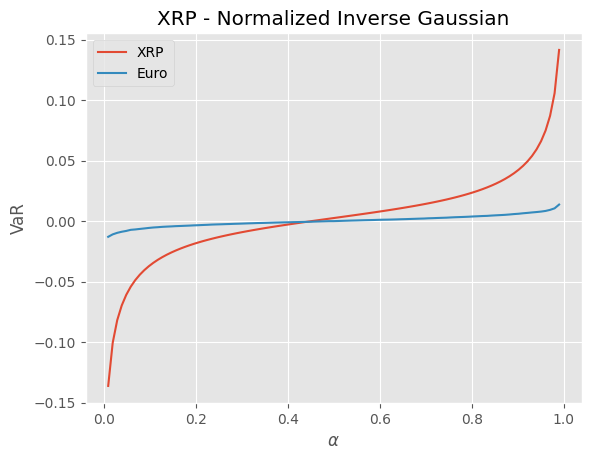

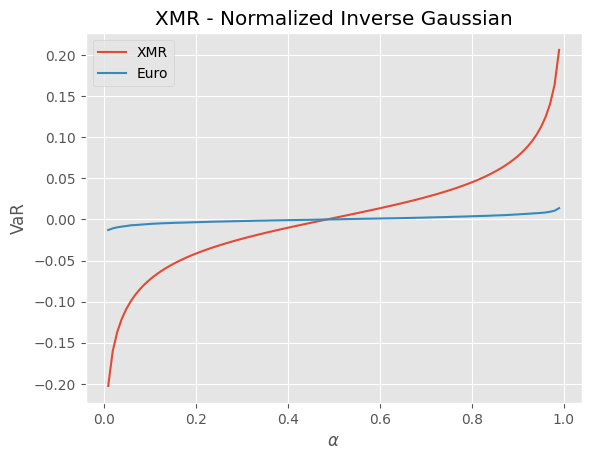

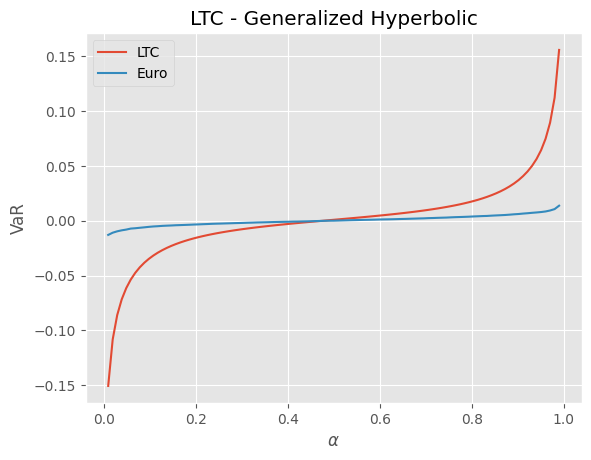

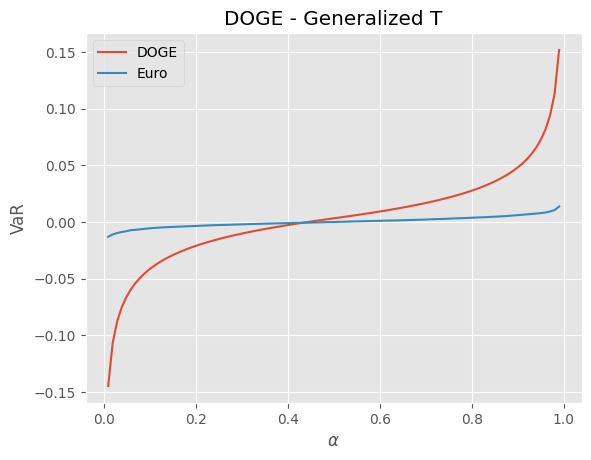

In [25]:
for coin, dist in best_dists.items():
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    def quantile(x): return np.vectorize(pydist.quantile)(x)
    var = quantile(q)
    fig, ax = plt.subplots()
    ax.plot(q, var, label=coin)
    plt.plot(q, euro_quantile, label = 'Euro')
    ax.set_title(f"{coin} - {pydist.name}")
    ax.set_ylabel('VaR')
    ax.set_xlabel(r'$\alpha$')

    plt.legend();
    plt.savefig(f'../plots/var/{coin}_var.png')
    plt.show()


### ES Plots

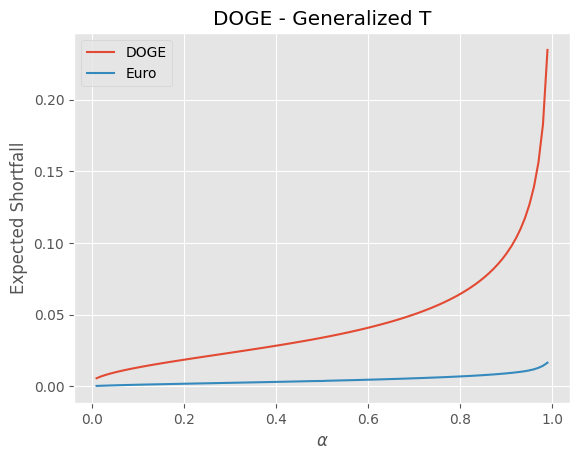

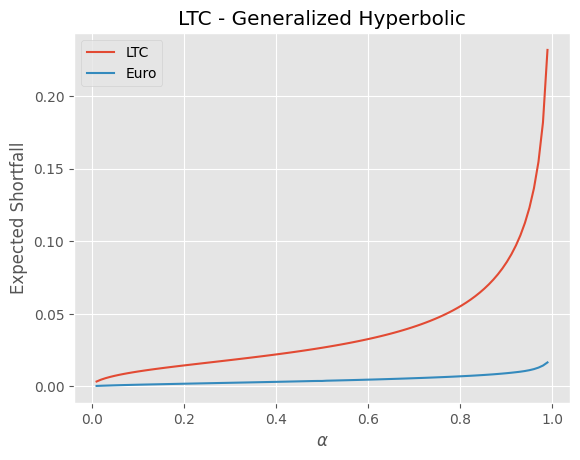

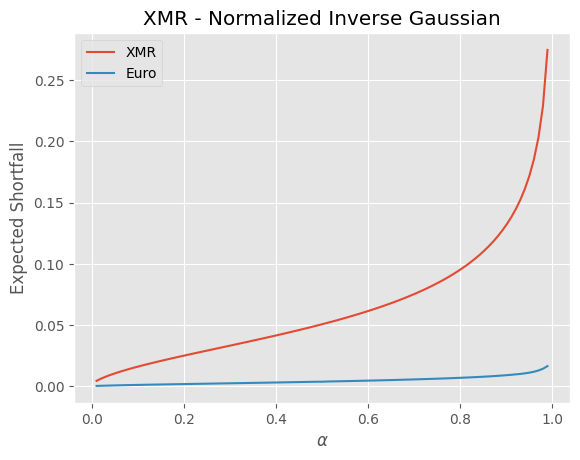

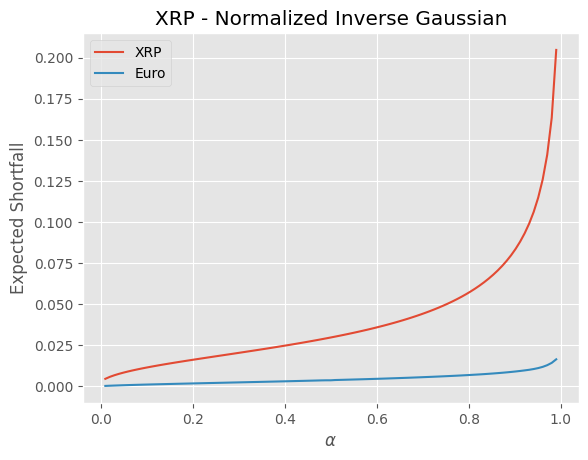

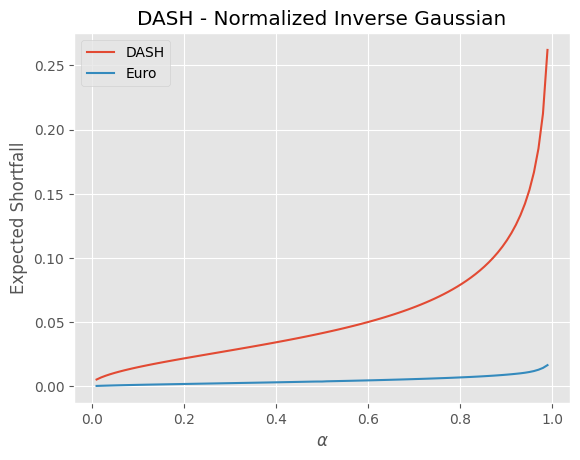

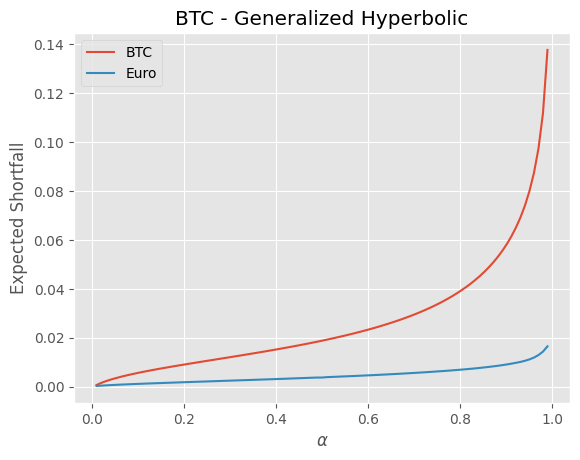

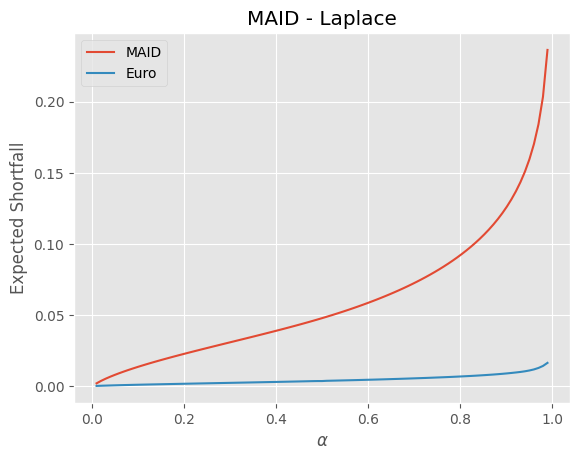

In [27]:
def empirical_es(var, data):
    return np.sum(np.multiply(data >= var, data))/np.sum(data >= var)


empirical_es_euro = [empirical_es(
    var, euro['log_return'].dropna()) for var in euro_quantile]

for coin, dist in reversed(best_dists.items()):
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    es_func = lambda x: np.vectorize(pydist.expected_shortfall)(x)

    es = es_func(q)
    fig, ax = plt.subplots()
    ax.plot(q, es, label=coin)
    ax.plot(q, empirical_es_euro, label = 'Euro')

    ax.set_ylabel('Expected Shortfall')
    ax.set_xlabel(r'$\alpha$')

    ax.set_title(f"{coin} - {pydist.name}")
    plt.legend()
    plt.savefig(f'../plots/es/{coin}_es.png')
    plt.show();
